# Customer Analytics in FMGC Industry (Part 2)
#### by Sooyeon Won

### Keywords 

- Marketing Mix 
- STP framework (Segmentation, Targeting, Positioning) 
- Purchase Analytics 
- Predictive Analyses
- Price Elasticity
- Modeling Purchase Quantity

### Contents 

<ul>
<li><a href="#Introduction">1. Introduction</a></li> 
<li><a href="#Preparation">2. Data Preparation</a></li>
<li><a href="#Exploration">3. Data Exploration</a></li>
<li><a href="#Analysis">4. Data Analysis</a></li>
&emsp;4.1. Customer Analytics<br>
&emsp;4.2. Purchase Analytics <br>
&emsp;&emsp;&emsp;i. Descriptive Analyses by Segment <br>
&emsp;&emsp;&emsp;&emsp;&emsp; i-1. The Proportion of each Segment <br>
&emsp;&emsp;&emsp;&emsp;&emsp; i-2. Purchase Occasions and Purchase Incidences <br>
&emsp;&emsp;&emsp;&emsp;&emsp; i-3. Brand Chocie <br>
&emsp;&emsp;&emsp;&emsp;&emsp; i-4. Revenue Comparison between segments <br>
&emsp;&emsp;&emsp;ii. Predictive Analyses <br>
&emsp;&emsp;&emsp;&emsp;&emsp; ii-1. Modeling Purchase Incidence<br>
&emsp;&emsp;&emsp;&emsp;&emsp; ii-2. Modeling Brand Choice <br>
&emsp;&emsp;&emsp;&emsp;&emsp; ii-3. Modeling Purchase Quantity <br>
<li><a href="#Conclusion">5. Conclusion</a></li>
</ul>


## 4. Data Analysis
### 4.2. Purchase Analytics
- Data Preparation from Part 1
- ii. Predictive Analyses <br>
&emsp;&emsp;&emsp; ii-1. Modeling Purchase Incidence<br>
&emsp;&emsp;&emsp; ii-2. Modeling Brand Choice** <br>
&emsp;&emsp;&emsp; **ii-3. Modeling Purchase Quantity** <br>


### Data Preparation from Part 1

In [1]:
# Import the relevant libraries 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import matplotlib.axes as axs
%matplotlib inline
plt.rc("font", size=14)
import seaborn as sns
sns.set()
sns.set(style="whitegrid", color_codes=True)

from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans 

# Import pickle in order to be able to load our pickled objects.
import pickle

# Import the Linear Regression module from sk learn for the quantity model.
from sklearn.linear_model import LinearRegression

In [2]:
# Load data
purchase_df = pd.read_csv('purchase data.csv', index_col = 0)
price_elasticities = pd.read_csv('price_elasticities_2.csv', index_col = 0)

# Import Scaler, PCA, K-Means Object from the previous analysis
scaler = pickle.load(open('scaler.pickle', 'rb'))
pca = pickle.load(open('pca.pickle', 'rb'))
kmeans_pca = pickle.load(open('kmeans_pca.pickle', 'rb'))

# Standardisation
features = purchase_df[['Sex', 'Marital status', 'Age', 'Education', 'Income', 'Occupation', 'Settlement size']]
purchase_segm_std = scaler.transform(features)
# Apply PCA
purchase_segm_pca = pca.transform(purchase_segm_std)
# Segment data
purchase_segm_kmeans_pca = kmeans_pca.predict(purchase_segm_pca)

# Create a copy of the data frame
purchase_predictors = purchase_df.copy()

# Add segment labels
purchase_predictors['Segment'] = purchase_segm_kmeans_pca
segment_dummies = pd.get_dummies(purchase_segm_kmeans_pca, prefix = 'Segment', prefix_sep = '_')
purchase_predictors = purchase_predictors.reset_index()
purchase_predictors = purchase_predictors.merge(segment_dummies, how='inner',
                                                left_on = purchase_predictors.index,
                                                right_on = segment_dummies.index)

In [3]:
df_pa = purchase_predictors.set_index('ID').iloc[:,1:].copy()
df_pa.head() # Data is ready to conduct predictive analysis 

,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,...,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
ID,,,,,,,,,,,,,,,,,,,,,
200000001,1,0,0,0,0,0,1.59,1.87,2.01,2.09,...,47,1,110866,1,0,0,1,0,0,0
200000001,11,0,0,0,0,0,1.51,1.89,1.99,2.09,...,47,1,110866,1,0,0,1,0,0,0
200000001,12,0,0,0,0,0,1.51,1.89,1.99,2.09,...,47,1,110866,1,0,0,1,0,0,0
200000001,16,0,0,0,0,0,1.52,1.89,1.98,2.09,...,47,1,110866,1,0,0,1,0,0,0
200000001,18,0,0,0,0,0,1.52,1.89,1.99,2.09,...,47,1,110866,1,0,0,1,0,0,0


### ii. Predictive Analysis 
In this section of predictive analysis, I apply a supervised machine learning model to estimate price elasticities and predict their effect on purchase quantity. As before, customers had visited the store, and chose a brand, and not they are deciding what quantity or how many units of the product category of interest will the customer buy.

### ii-3. Modelling Purchase Quantity<br>
<li><a href="#PE_PQ">ii-3-1. Price Elasticity of Purchase Quantity</a></li>
<li><a href="#MELR">ii-3-2. Model Estimation: Multi-Linear Regression</a></li>
<li><a href="#PEE">ii-3-3. Price Elasticity Estimation</a></li> 

> First I built a statistical model to estimate purchase quantity for each customer on each shopping trip. Then the price elasticity of purchase quantity under different conditions is calculated. To do so, I employ linear regression, since we have a numeric, continuous variables to be predicted and the linear regression algorithm is intuitive to interpret.


<a id='PE_PQ'></a>
### ii-3-1. Price Elasticity of Purchase Quantity

Customers have visited the store and decided to purchase a product from the product category. In other words, I only focus on the datapoints that a sale for chocolates occurred. The quantity won't be zero but rather one or above to model that outcome. 

In [4]:
purchase_quantity =  df_pa.query('Incidence ==1')
purchase_quantity.head()

,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,...,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
ID,,,,,,,,,,,,,,,,,,,,,
200000001,28,1,2,2,0,0,1.50,1.90,1.99,2.09,...,47,1,110866,1,0,0,1,0,0,0
200000001,58,1,5,1,0,0,1.39,1.90,1.91,2.12,...,47,1,110866,1,0,0,1,0,0,0
200000001,110,1,1,2,0,0,1.47,1.90,1.99,1.97,...,47,1,110866,1,0,0,1,0,0,0
200000001,142,1,4,1,0,0,1.21,1.35,1.99,2.16,...,47,1,110866,1,0,0,1,0,0,0
200000001,183,1,2,3,0,0,1.46,1.88,1.97,1.89,...,47,1,110866,1,0,0,1,0,0,0


In [5]:
# Create brand dummies, for each of the 5 brands.
purchase_quantity = pd.get_dummies(purchase_quantity, columns = ['Brand'], prefix = 'Brand', prefix_sep = '_')

In [6]:
# Turn off scientific notation in pandas 
pd.set_option('display.float_format', lambda x: '%.2f' % x)
purchase_quantity.describe()

,Day,Incidence,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,Price_5,...,Segment,Segment_0,Segment_1,Segment_2,Segment_3,Brand_1,Brand_2,Brand_3,Brand_4,Brand_5
count,14638.00,14638.00,14638.00,14638.00,14638.00,14638.00,14638.00,14638.00,14638.00,14638.00,...,14638.00,14638.00,14638.00,14638.00,14638.00,14638.00,14638.00,14638.00,14638.00,14638.00
mean,359.61,1.00,2.77,1.54,0.41,1.38,1.76,2.01,2.16,2.65,...,1.34,0.29,0.30,0.18,0.23,0.09,0.31,0.06,0.20,0.34
std,205.35,0.00,1.80,2.06,0.49,0.09,0.18,0.05,0.09,0.10,...,1.13,0.46,0.46,0.38,0.42,0.29,0.46,0.23,0.40,0.47
min,1.00,1.00,1.00,0.00,0.00,1.10,1.26,1.87,1.76,2.11,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,175.00,1.00,2.00,0.00,0.00,1.34,1.57,1.97,2.12,2.63,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,355.00,1.00,2.00,0.00,0.00,1.39,1.88,2.01,2.18,2.67,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,532.00,1.00,3.00,4.00,1.00,1.47,1.89,2.06,2.24,2.70,...,2.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00
max,727.00,1.00,15.00,5.00,1.00,1.59,1.90,2.14,2.26,2.80,...,3.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


> The descriptive analysis of the purchase quantitiy data frame, shows that quantity ranges from 1 to 15. It has an average value of 2.8, which means that more often than not our customers buy more than 1 chocolate candy bar. We expect that the many purchase occasions more than one chocolate candy bar was purchased.

#### Variables selection 

In [7]:
# Select the varibles which have a clear logical relationship between the quantity purchased. 
purchase_quantity.columns.values

array(['Day', 'Incidence', 'Quantity', 'Last_Inc_Brand',
       'Last_Inc_Quantity', 'Price_1', 'Price_2', 'Price_3', 'Price_4',
       'Price_5', 'Promotion_1', 'Promotion_2', 'Promotion_3',
       'Promotion_4', 'Promotion_5', 'Sex', 'Marital status', 'Age',
       'Education', 'Income', 'Occupation', 'Settlement size', 'Segment',
       'Segment_0', 'Segment_1', 'Segment_2', 'Segment_3', 'Brand_1',
       'Brand_2', 'Brand_3', 'Brand_4', 'Brand_5'], dtype=object)

- **ID:** It doesn't seems that there is a clear logical relationship with quantity. 
- **Last_Inc_Brand, Last_Inc_Quantity (last incidents brand, quantity):** The last purchase quantity can be used as the purchase behavior of this particular customer. However, it doesn't seem that there is a clear logical relationship with quantity. 
- **'Sex', 'Marital status', 'Age', 'Education', 'Income', 'Occupation', 'Settlement size', 'Segment', 'Segment_0', 'Segment_1', 'Segment_2', 'Segment_3':** I personally support the idea that the amount of product purchased can be different from the demographical factors. So I decided to include the features. Considering that the demographic features are used to predict each segment, we should include either segment variables or the demographic variables. Otherwise, the model will suffer from multicollinearity issues. 
- **Brand** dummies are chosen, indicating which brand was chosen during the previous shopping trip. However it does not show the precise quantity purchased on the last shopping trip. 

In [8]:
# Calculate price of the product that is chosen at this incidence
purchase_quantity['Price_Incidence'] = (purchase_quantity['Brand_1'] * purchase_quantity['Price_1'] +
                                        purchase_quantity['Brand_2'] * purchase_quantity['Price_2'] +
                                        purchase_quantity['Brand_3'] * purchase_quantity['Price_3'] +
                                        purchase_quantity['Brand_4'] * purchase_quantity['Price_4'] +
                                        purchase_quantity['Brand_5'] * purchase_quantity['Price_5'] )

# Indicate incidences whether each brand is purchased with/ without promotion
purchase_quantity['Promotion_Incidence'] = (purchase_quantity['Brand_1'] * purchase_quantity['Promotion_1'] +
                                            purchase_quantity['Brand_2'] * purchase_quantity['Promotion_2'] +
                                            purchase_quantity['Brand_3'] * purchase_quantity['Promotion_3'] +
                                            purchase_quantity['Brand_4'] * purchase_quantity['Promotion_4'] +
                                            purchase_quantity['Brand_5'] * purchase_quantity['Promotion_5'] )

<a id='MELR'></a>
### ii-3-2. Model Estimation: Multi-Linear Regression

In [9]:
inputs = purchase_quantity[['Sex', 'Price_Incidence', 'Promotion_Incidence' ]]
print(inputs.shape)
inputs.head()

(14638, 3)


,Sex,Price_Incidence,Promotion_Incidence
ID,,,
200000001,0,1.90,0
200000001,0,2.62,1
200000001,0,1.47,0
200000001,0,2.16,0
200000001,0,1.88,0


In [10]:
output = purchase_quantity['Quantity']
output.head()

ID
200000001    2
200000001    1
200000001    2
200000001    1
200000001    3
Name: Quantity, dtype: int64

In [11]:
# Define a Linear Regression Model
model_quantity = LinearRegression()
model_quantity.fit(inputs, output)

LinearRegression()

In [12]:
# Linear Regression Model. The coefficients for price and promotion are both negative. 
# It appears that promotion reflects negatively on the purchase quantity of the average client, which is unexpected.
np.round(model_quantity.coef_,4)

array([ 0.1618, -0.7756, -0.0922])

- In general, coefficients show the change in the dependent variable that is going to occur with a unit change in the respective independent variable. 
- The first coefficient refers to Sex. Since the coefficient is positive, we can interpret that females (Sex =1) are likely to purchase ca.  0.1618 units more chocolates than males (Sex = 0).  
- The second coefficient is related to the change of price of the purchased product. For each dollar increase in price, ca. 0.7756 units less chocolates will be bought. This is intuitive, as price increases, purchase quantity naturally decreases. 
- According to the last coefficient, when there is a promotion ca. 0.0922 units less will be bought. In other words, people would buy a bit less when there is a promotion. This is quite counter-intuitive. 
- In my opinion, this might be occurred due to over-simplified regression model. After backwards variables selection, only 4 predicters are left. There might be some other important features which affect on purchase quantity, and they are missing in the given dataset. 
- Another plausible explanation could be we are considering the "average customer", not any particular segment. Or it is also possible that a promotion is prompting a customer to try out a new brand. In that case, we would not expect them to buy many chocolate bars but a single one.

<a id='PEE'></a>
### ii-3-3. Price Elasticity Estimation vs. Promotion

Price elasticity of purchase quantity is the percentage change in purchase quantity and response to a one percent change in the unit price of the chosen brand, assuming nothing else but the price changes. Note that price elasticity is often associated with price elasticity of demand. <br>
Like before I assume that the price can change across a wide range of values from USD 0,5 to 3,5. <br>
Simply, I looked at the price elasticity of purchase quantity under two conditions: With / Without promotion. <br>

In [13]:
price_range = np.arange(0.5, 3.5, 0.01)

In [14]:
len(price_range)

300

In [15]:
np.random.binomial(1, 0.5, len(price_range)).mean()

0.52

In [16]:
# Examine the price elasticity of purchase quantity with active promotional activities for each price point.
price_elasticity_quantity = pd.DataFrame({'Sex' : 0.5,  
                                          'Price_Incidence':price_range, 
                                          'Promotion_Incidence' :1,              # With Promotion                           
                                          'No_Promotion_Incidence' : 0},         # With Promotion     
                                         index = np.arange(price_range.size))

In [17]:
# Take the coefficient for price.
beta_quantity = model_quantity.coef_[1]
np.round(beta_quantity, 4)

-0.7756

In [18]:
# Find the new predicted quantities.
predict_quantity_prom = model_quantity.predict(price_elasticity_quantity.iloc[:, :3])
predict_quantity_prom_x = model_quantity.predict(price_elasticity_quantity.iloc[:, np.r_[0:2,3]])

### Price Elasticity of Demand 

I calculate probability of purchase quantity with the help of a linear regression model. Then, using the obtained probabilities, we can determine the price elasticities as: The beta coefficient for price times Price divided by the purchase quantity.

$$ E = -\beta(Own Product Price)/Quantity(purchase) $$ 

[Price Elasticity - Reference](https://365datascience.com/price-elasticity/)

In [19]:
# Calculate the price elasticity with the new formula. It is the beta coefficient for price multiplied by price
# and divided by the purchase quantity.
price_elasticity_quantity_promotion_yes = beta_quantity * price_range / predict_quantity_prom
price_elasticity_quantity_promotion_no = beta_quantity * price_range / predict_quantity_prom_x

In [20]:
price_elasticities.loc['PE_Quantity_Prom_Yes'] = price_elasticity_quantity_promotion_yes
price_elasticities.loc['PE_Quantity_Prom_No'] = price_elasticity_quantity_promotion_no
pd.options.display.max_columns = None
# Master dataframe of price elasticity
price_elasticities.to_csv('price_elasticities_Master.csv')
price_elasticities 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
Price_Point,0.50,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59,0.60,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.70,0.71,0.72,0.73,0.74,0.75,0.76,0.77,0.78,0.79,0.80,0.81,0.82,0.83,0.84,0.85,0.86,0.87,0.88,0.89,0.90,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1.00,1.01,1.02,1.03,1.04,1.05,1.06,1.07,1.08,1.09,1.10,1.11,1.12,1.13,1.14,1.15,1.16,1.17,1.18,1.19,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.29,1.30,1.31,1.32,1.33,1.34,1.35,1.36,1.37,1.38,1.39,1.40,1.41,1.42,1.43,1.44,1.45,1.46,1.47,1.48,1.49,1.50,1.51,1.52,1.53,1.54,1.55,1.56,1.57,1.58,1.59,1.60,1.61,1.62,1.63,1.64,1.65,1.66,1.67,1.68,1.69,1.70,1.71,1.72,1.73,1.74,1.75,1.76,1.77,1.78,1.79,1.80,1.81,1.82,1.83,1.84,1.85,1.86,1.87,1.88,1.89,1.90,1.91,1.92,1.93,1.94,1.95,1.96,1.97,1.98,1.99,2.00,2.01,2.02,2.03,2.04,2.05,2.06,2.07,2.08,2.09,2.10,2.11,2.12,2.13,2.14,2.15,2.16,2.17,2.18,2.19,2.20,2.21,2.22,2.23,2.24,2.25,2.26,2.27,2.28,2.29,2.30,2.31,2.32,2.33,2.34,2.35,2.36,2.37,2.38,2.39,2.40,2.41,2.42,2.43,2.44,2.45,2.46,2.47,2.48,2.49,2.50,2.51,2.52,2.53,2.54,2.55,2.56,2.57,2.58,2.59,2.60,2.61,2.62,2.63,2.64,2.65,2.66,2.67,2.68,2.69,2.70,2.71,2.72,2.73,2.74,2.75,2.76,2.77,2.78,2.79,2.80,2.81,2.82,2.83,2.84,2.85,2.86,2.87,2.88,2.89,2.90,2.91,2.92,2.93,2.94,2.95,2.96,2.97,2.98,2.99,3.00,3.01,3.02,3.03,3.04,3.05,3.06,3.07,3.08,3.09,3.10,3.11,3.12,3.13,3.14,3.15,3.16,3.17,3.18,3.19,3.20,3.21,3.22,3.23,3.24,3.25,3.26,3.27,3.28,3.29,3.30,3.31,3.32,3.33,3.34,3.35,3.36,3.37,3.38,3.39,3.40,3.41,3.42,3.43,3.44,3.45,3.46,3.47,3.48,3.49
Mean_PE,-0.10,-0.10,-0.10,-0.11,-0.11,-0.12,-0.12,-0.13,-0.13,-0.14,-0.14,-0.15,-0.15,-0.16,-0.17,-0.17,-0.18,-0.19,-0.19,-0.20,-0.21,-0.21,-0.22,-0.23,-0.24,-0.24,-0.25,-0.26,-0.27,-0.28,-0.29,-0.30,-0.31,-0.32,-0.33,-0.34,-0.35,-0.36,-0.37,-0.38,-0.39,-0.41,-0.42,-0.43,-0.44,-0.46,-0.47,-0.48,-0.50,-0.51,-0.53,-0.54,-0.56,-0.57,-0.59,-0.61,-0.62,-0.64,-0.66,-0.67,-0.69,-0.71,-0.73,-0.75,-0.77,-0.79,-0.81,-0.83,-0.85,-0.87,-0.89,-0.91,-0.94,-0.96,-0.98,-1.00,-1.03,-1.05,-1.08,-1.10,-1.13,-1.15,-1.18,-1.20,-1.23,-1.26,-1.29,-1.31,-1.34,-1.37,-1.40,-1.43,-1.46,-1.49,-1.52,-1.55,-1.58,-1.61,-1.64,-1.67,-1.70,-1.73,-1.77,-1.80,-1.83,-1.87,-1.90,-1.93,-1.97,-2.00,-2.04,-2.07,-2.11,-2.14,-2.18,-2.21,-2.25,-2.28,-2.32,-2.36,-2.39,-2.43,-2.47,-2.50,-2.54,-2.58,-2.61,-2.65,-2.69,-2.73,-2.77,-2.80,-2.84,-2.88,-2.92,-2.96,-2.99,-3.03,-3.07,-3.11,-3.15,-3.18,-3.22,-3.26,-3.30,-3.34,-3.38,-3.42,-3.45,-3.49,-3.53,-3.57,-3.61,-3.64,-3.68,-3.72,-3.76,-3.80,-3.83,-3.87,-3.91,-3.95,-3.98,-4.02,-4.06,-4.10,-4.13,-4.17,-4.21,-4.24,-4.28,-4.32,-4.35,-4.39,-4.43,-4.46,-4.50,-4.54,-4.57,-4.61,-4.64,-4.68,-4.71,-4.75,-4.78,-4.82,-4.85,-4.89,-4.92,-4.96,-4.99,-5.02,-5.06,-5.09,-5.13,-5.16,-5.19,-5.23,-5.26,-5.29,-5.33,-5.36,-5.39,-5.42,-5.46,-5.49,-5.52,-5.55,-5.59,-5.62,-5.65,-5.68,-5.71,-5.74,-5.77,-5.81,-5.84,-5.87,-5.90,-5.93,-5.96,-5.99,-6.02,-6.05,-6.08,-6.11,-6.14,-6.17,-6.20,-6.23,-6.26,-6.

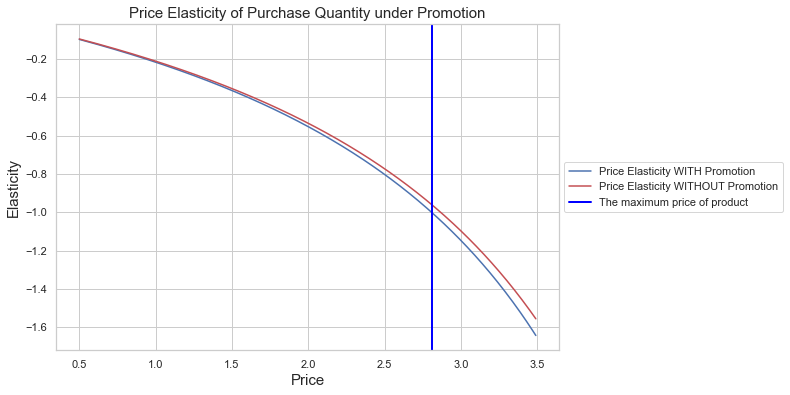

In [21]:
# Plot the two elasticities side by side. 
plt.figure(figsize = (9, 6))
plt.plot(price_range, price_elasticity_quantity_promotion_yes, color = 'b', label = 'Price Elasticity WITH Promotion') 
plt.plot(price_range, price_elasticity_quantity_promotion_no, color = 'r', label = 'Price Elasticity WITHOUT Promotion') 
plt.xlabel('Price',  fontsize =15)
plt.ylabel('Elasticity',  fontsize =15)
plt.title('Price Elasticity of Purchase Quantity under Promotion',  fontsize =15)
plt.axvline(2.81, color='blue', linewidth=2, label = 'The maximum price of product')
# show the legend
plt.legend( bbox_to_anchor = (1, 0.5), loc = 6)
plt.show()

- The plot shows that that customers are a little bit **more elastic** when there is a promotion. However overall customers are inelastic towards purchase quantity for all prices from 0,5 dollars to ca. 2.80 dollars. The most expensive brand cost 2,80 dollars. below 2,80 dollars. The two lines practically overlap at many of the price points.  Thus, neither price nor promotions shifts appear to affect the customer's decision. based on this analysis.

<a id='Conclusion'></a>
## 5. Conclusion

> Throughout this analysis, I analysed customers in FMCG industry. 
>- Part1: Applying several basic techniques such as K-Means clustering and dimensionality reduction with PCA, I conducted segmentation marketing efforts in the first part of analysis.
>- Part2: Then in the purchase analytics. I combined the segmentation results with some descriptive statistics. This analysis allowed me to extract some unexpected insights about the revenue distribution by brand and by customer segment. Finally, by modelling with linear and logistic regression, I quantified the elasticities of purchase probability brand choice and purchase quantity. The findings provide a fresh perspective on the different pricing strategies we could pursue in order to sustain or maximize the revenue.
